/tmp/ipykernel_59566/694058754.py:303: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to make room for colorbar


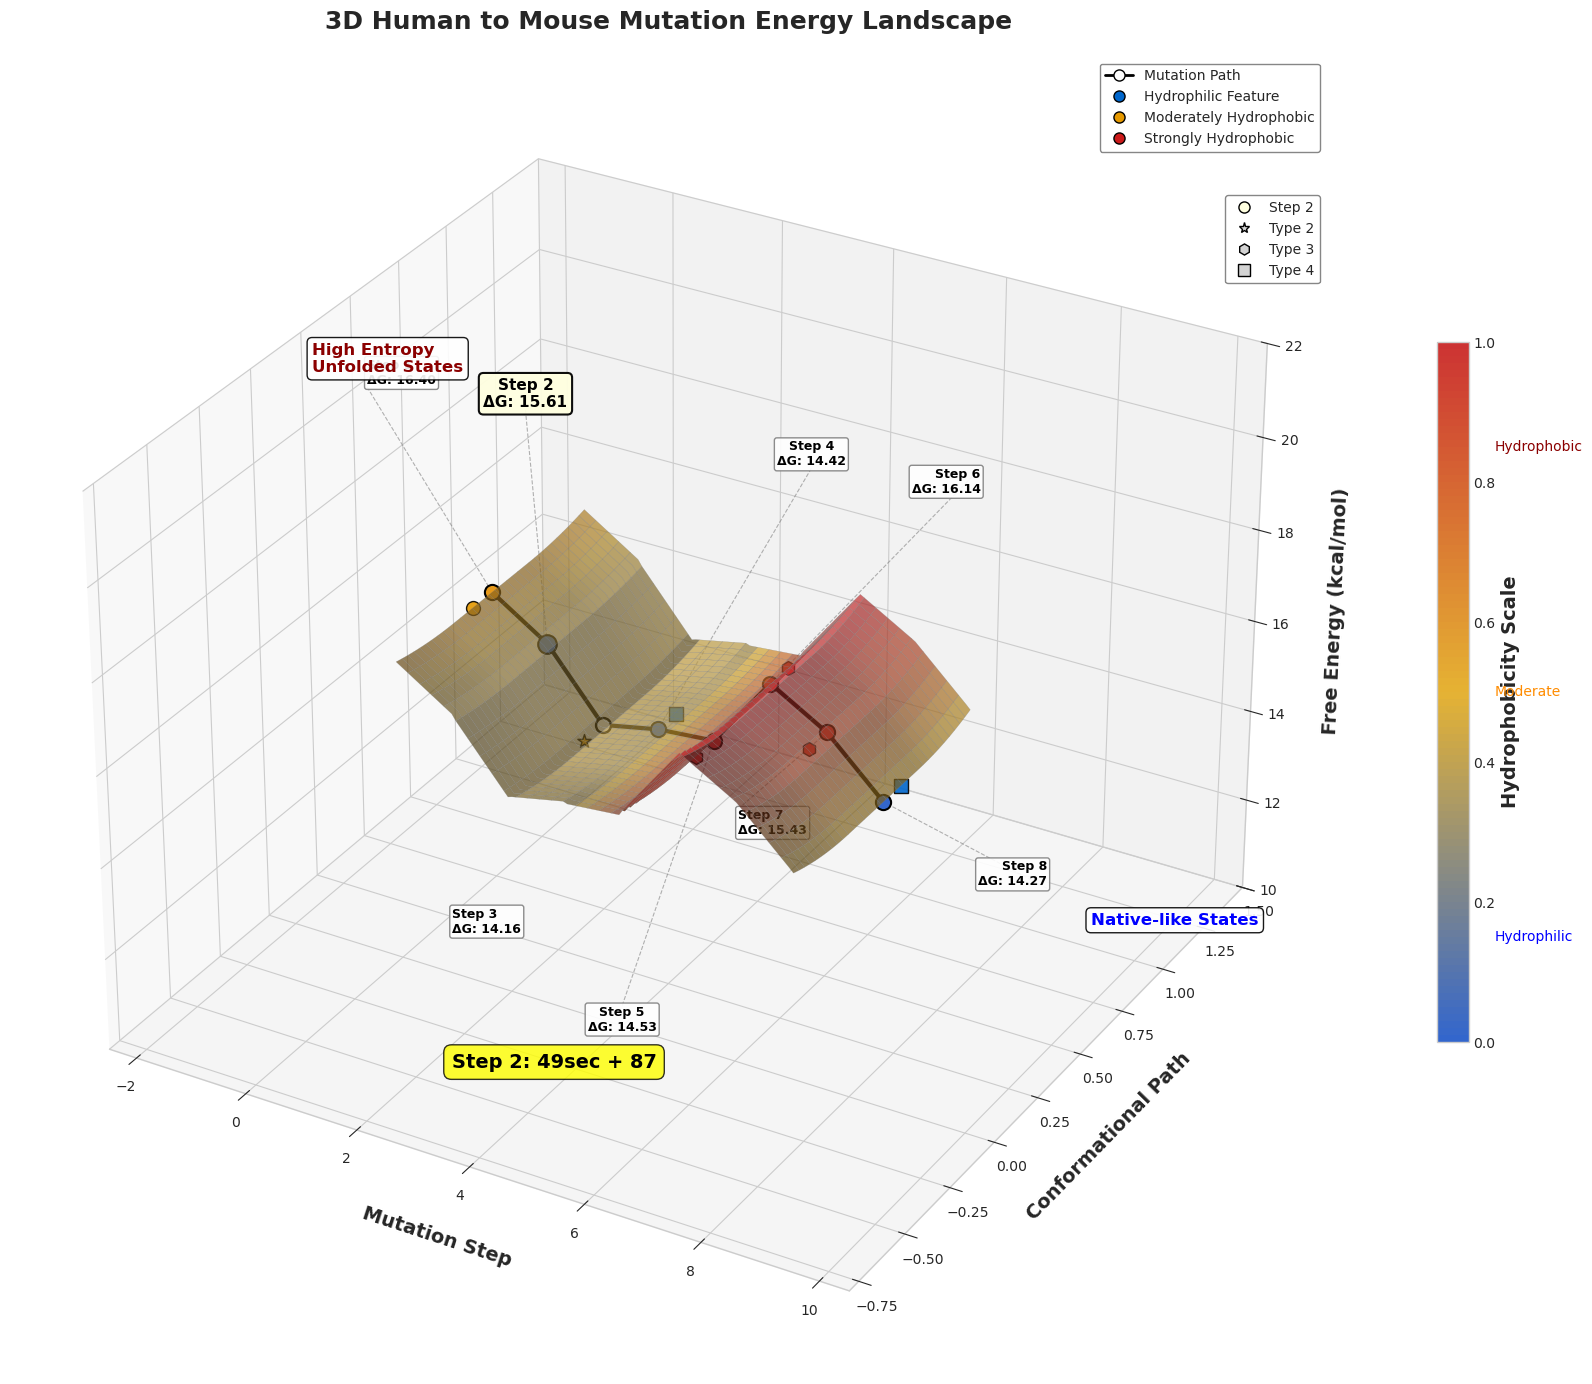

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data - updated with human to mouse mutations
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7])
barriers = np.array([16.4, 15.61, 14.16, 14.42, 14.53, 16.14, 15.43, 14.27])
mutations = [
    "49sec",
    "49sec + 87",
    "49sec + 87 + 99",
    "49sec + 87 + 99 + 47",
    "49sec + 87 + 99 + 47 + 143",
    "49sec + 87 + 99 + 47 + 143 + 60",
    "49sec + 87 + 99 + 47 + 143 + 60 + 104",
    "49sec + 87 + 99 + 47 + 143 + 60 + 104 + 142"
]

# Add features - hydrophobicity scales
# Higher values = more hydrophobic
hydrophobicity_values = [2.5, 1.8, 2.0, 1.8, 4.2, 4.5, 3.8, 1.9]

# Define hydrophilic/hydrophobic classification
def classify_aa(h_value):
    if h_value < 2.0:
        return "Hydrophilic"
    elif h_value < 3.0:
        return "Moderate"
    else:
        return "Hydrophobic"

# Get classification for each step
mutation_class = [classify_aa(h) for h in hydrophobicity_values]

# Volume values (approximate)
mutation_volume = [108.5, 88.6, 116.0, 88.6, 140.0, 166.7, 166.7, 162.9]

# More distinct color scheme based on hydrophobicity
def hydrophobicity_color(h_value):
    if h_value < 2.0:  # Hydrophilic
        return (0.2, 0.4, 0.8)  # Deeper blue
    elif h_value < 3.0:  # Moderately hydrophobic
        return (0.9, 0.6, 0.1)  # Distinct orange
    else:  # Strongly hydrophobic
        return (0.8, 0.2, 0.2)  # Deeper red

colors_custom = [hydrophobicity_color(h) for h in hydrophobicity_values]

# Create figure with more space
fig = plt.figure(figsize=(16, 14))

# Create 3D surface plot
ax = plt.axes(projection='3d')

# Create smooth surface function for 3D plot with enhanced features
def create_smooth_surface(levels, barriers, hydrophobicity_values, volume_values):
    x = np.linspace(0, len(levels)-1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros_like(X)
    hydro_surface = np.zeros_like(X)
    
    for i in range(len(X)):
        for j in range(len(X[0])):
            xval = X[i][j]
            if xval <= levels[0]:
                Z[i][j] = barriers[0]
                hydro_surface[i][j] = hydrophobicity_values[0]
            elif xval >= levels[-1]:
                Z[i][j] = barriers[-1]
                hydro_surface[i][j] = hydrophobicity_values[-1]
            else:
                idx = np.searchsorted(levels, xval)
                t = (xval - levels[idx-1]) / (levels[idx] - levels[idx-1])
                Z[i][j] = barriers[idx-1] + t * (barriers[idx] - barriers[idx-1])
                hydro_surface[i][j] = hydrophobicity_values[idx-1] + t * (hydrophobicity_values[idx] - hydrophobicity_values[idx-1])
            
            # Create funnel shape
            center_y = 0.5
            dist_from_center = abs(Y[i][j] - center_y)
            
            # Make a deeper valley along the center path
            if dist_from_center < 0.2:
                variance = 0
            else:
                # Add volume influence to the landscape
                vol_idx = min(int(xval), len(volume_values)-1)
                if vol_idx < 0:
                    vol_idx = 0
                volume_factor = volume_values[vol_idx] / max(volume_values)
                variance = 3 * (dist_from_center - 0.2)**2 * volume_factor
                
            Z[i][j] += variance
            
    return X, Y, Z, hydro_surface

X_smooth, Y_smooth, Z_smooth, hydro_surface = create_smooth_surface(
    levels, barriers, hydrophobicity_values, mutation_volume)

# Create custom colormap for hydrophobicity with more distinct colors
hydro_cmap = LinearSegmentedColormap.from_list(
    'hydrophobicity', 
    [(0, (0.2, 0.4, 0.8)),      # Deep blue (hydrophilic)
     (0.5, (0.9, 0.7, 0.2)),    # Distinct orange (moderate)
     (1, (0.8, 0.2, 0.2))],     # Deep red (hydrophobic)
    N=100
)

# Plot the smooth surface colored by hydrophobicity
surf = ax.plot_surface(X_smooth, Y_smooth, Z_smooth, 
                     facecolors=hydro_cmap(hydro_surface/max(hydrophobicity_values)),
                     alpha=0.7, 
                     edgecolor='gray',
                     rstride=3, cstride=3,
                     linewidth=0.2, 
                     antialiased=True,
                     shade=True)

# Plot a highlighted path on the surface
path_y = np.ones(len(levels)) * 0.5
ax.plot(levels, path_y, barriers, color='black', linewidth=3, 
       marker='o', markersize=10, markerfacecolor='white', markeredgecolor='black', 
       label="Mutation Path")

# *** COMPLETELY REDESIGNED TEXT POSITIONS TO ELIMINATE OVERLAPS ***
# Create text positions with extreme spacing to eliminate all overlaps
text_positions = [
    {"x": -1.5, "y": 0.3, "z": 21, "ha": "left", "va": "bottom"},  # Step 1 - far left
    {"x": 1, "y": 0.4, "z": 21, "ha": "center", "va": "bottom"},   # Step 2 - above
    {"x": 2, "y": -0.3, "z": 13, "ha": "left", "va": "top"},       # Step 3 - lower left
    {"x": 3.5, "y": 1.2, "z": 18, "ha": "center", "va": "bottom"}, # Step 4 - upper right
    {"x": 5, "y": -0.3, "z": 12, "ha": "center", "va": "top"},     # Step 5 - bottom
    {"x": 6.5, "y": 1.2, "z": 19, "ha": "right", "va": "top"},     # Step 6 - far upper right
    {"x": 7.0, "y": -0.3, "z": 17, "ha": "left", "va": "top"},     # Step 7 - lower right
    {"x": 9.0, "y": 0.8, "z": 12, "ha": "right", "va": "bottom"}   # Step 8 - far right
]

# Add points for each mutation with carefully positioned text to avoid overlap
for i in range(len(levels)):
    # More distinct markers
    marker_size = 120
    # Make step 2 more visible with larger marker
    if i == 1:  # Step 2 (index 1)
        marker_size = 180
        
    ax.scatter(levels[i], 0.5, barriers[i], color=colors_custom[i], s=marker_size, 
              edgecolor='black', linewidth=1.5, zorder=100)
    
    # Use the pre-defined non-overlapping positions
    pos = text_positions[i]
    
    # Shorter labels with minimum information
    level_label = f"Step {i+1}\nΔG: {barriers[i]:.2f}"
    
    # Make Step 2 label larger and more noticeable
    fontsize = 9
    fontweight = 'bold'
    bbox_props = dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2', edgecolor='gray')
    
    if i == 1:  # Step 2 (index 1)
        fontsize = 11
        fontweight = 'bold'
        bbox_props = dict(facecolor='lightyellow', alpha=0.95, boxstyle='round,pad=0.3', 
                         edgecolor='black', linewidth=1.5)
        level_label = f"Step 2\nΔG: {barriers[1]:.2f}"
    
    # Add connection lines from text labels to points for better clarity
    connector_x = [pos["x"], levels[i]]
    connector_y = [pos["y"], 0.5]
    connector_z = [pos["z"], barriers[i]]
    
    # Only add connectors for positions that are far from their points
    distance = np.sqrt((pos["x"] - levels[i])**2 + (pos["y"] - 0.5)**2 + (pos["z"] - barriers[i])**2)
    if distance > 2:
        ax.plot(connector_x, connector_y, connector_z, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
    
    ax.text(pos["x"], pos["y"], pos["z"], level_label,
           color='black', fontsize=fontsize, ha=pos["ha"], va=pos["va"], 
           fontweight=fontweight, bbox=bbox_props)

# Add feature symbols with different sizes and shapes based on properties
def add_feature_symbol(ax, x, y, z, symbol_type, hydro_value):
    # Color based on hydrophobicity - more distinct
    if hydro_value < 2.0:  # Hydrophilic
        color = (0.0, 0.4, 0.8)  # Deeper blue
    elif hydro_value < 3.0:  # Moderately hydrophobic
        color = (0.9, 0.6, 0.0)  # Distinct orange
    else:  # Strongly hydrophobic
        color = (0.8, 0.1, 0.1)  # Deeper red
        
    # Different marker shapes for different types
    if symbol_type == 0:
        marker = 'o'
    elif symbol_type == 2:
        marker = '*'
    elif symbol_type in [4, 5, 6]:
        marker = 'h'
    else:
        marker = 's'
    
    # Size adjustment, making step 2 larger
    size = 100
    if symbol_type == 1:  # Step 2
        size = 150
        
    # Use position adjustments to reduce overlap
    y_offset = -0.1 if symbol_type % 2 == 0 else 0.1
    
    # Smaller markers to reduce visual clutter
    ax.scatter(x, y+y_offset, z, color=color, s=size, marker=marker, 
              edgecolor='black', linewidth=1, alpha=0.9, zorder=100)

# Add feature representations along the path - without text to reduce clutter
for i in range(len(levels)):
    # Skip adding feature symbol at index 1 (Step 2) to avoid duplication
    if i != 1:
        add_feature_symbol(ax, levels[i], 0.5, barriers[i], 
                         i, hydrophobicity_values[i])

# Move colorbar to a better position
cax = fig.add_axes([0.93, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(cm.ScalarMappable(cmap=hydro_cmap), cax=cax)
cbar.set_label('Hydrophobicity Scale', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add text annotations for hydrophobicity scale with more space
cbar.ax.text(1.8, 0.15, "Hydrophilic", fontsize=10, ha='left', va='center', color='blue')
cbar.ax.text(1.8, 0.5, "Moderate", fontsize=10, ha='left', va='center', color='darkorange')
cbar.ax.text(1.8, 0.85, "Hydrophobic", fontsize=10, ha='left', va='center', color='darkred')

# Add text for the energy landscape regions - moved to extreme corners to avoid overlaps
ax.text(-2.5, 0.3, 21, "High Entropy\nUnfolded States", fontsize=12, color='darkred', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3'))
ax.text(9.5, 0.9, 11, "Native-like States", fontsize=12, color='blue', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3'))

# Add a special highlight for Step 2 with clearer positioning
# Move it to the bottom with no connection line to avoid overlaps
step2_highlight = ax.text(3.0, -0.6, 11, f"Step 2: {mutations[1]}", 
       fontsize=14, fontweight='bold', color='black',
       bbox=dict(facecolor='yellow', alpha=0.8, boxstyle='round,pad=0.4'))

# Add axes labels and title
ax.set_xlabel("Mutation Step", fontsize=14, fontweight='bold', labelpad=15)
ax.set_ylabel("Conformational Path", fontsize=14, fontweight='bold', labelpad=15)
ax.set_zlabel("Free Energy (kcal/mol)", fontsize=14, fontweight='bold', labelpad=15)
ax.set_title("3D Human to Mouse Mutation Energy Landscape", 
           fontsize=18, fontweight='bold', pad=20)

# Adjust view angle for better visibility and to reduce overlaps
ax.view_init(elev=30, azim=-60)
ax.grid(True, linestyle='--', alpha=0.5)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim(-2.5, len(levels)+2.5)  # Extended range for better spacing
ax.set_ylim(-0.8, 1.5)  # Extended y range
ax.set_zlim(10, 22)  # Extended z range for text placement

# Move legend to top right to avoid overlap with the plot content
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='o', linestyle='-', 
               markerfacecolor='white', markeredgecolor='black',
               markersize=8, linewidth=2, label="Mutation Path"),
    plt.Line2D([0], [0], marker='o', color=(0.0, 0.4, 0.8), markeredgecolor='black',
               markersize=8, linewidth=0, label="Hydrophilic Feature"),
    plt.Line2D([0], [0], marker='o', color=(0.9, 0.6, 0.0), markeredgecolor='black',
               markersize=8, linewidth=0, label="Moderately Hydrophobic"),
    plt.Line2D([0], [0], marker='o', color=(0.8, 0.1, 0.1), markeredgecolor='black',
               markersize=8, linewidth=0, label="Strongly Hydrophobic"),
]

# Use a separate legend for marker types to avoid overcrowding
legend1 = ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
         bbox_to_anchor=(1.0, 1.0), frameon=True, framealpha=0.95, edgecolor='gray')
ax.add_artist(legend1)

# Second legend for marker types
type_legend_elements = [
    plt.Line2D([0], [0], marker='o', color='lightyellow', markeredgecolor='black',
               markersize=8, linewidth=0, label="Step 2"),
    plt.Line2D([0], [0], marker='*', color='lightgray', markeredgecolor='black',
               markersize=8, linewidth=0, label="Type 2"),
    plt.Line2D([0], [0], marker='h', color='lightgray', markeredgecolor='black',
               markersize=8, linewidth=0, label="Type 3"),
    plt.Line2D([0], [0], marker='s', color='lightgray', markeredgecolor='black',
               markersize=8, linewidth=0, label="Type 4")
]
ax.legend(handles=type_legend_elements, loc='upper right', fontsize=10, 
         bbox_to_anchor=(1.0, 0.9), frameon=True, framealpha=0.95, edgecolor='gray')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to make room for colorbar
plt.show()

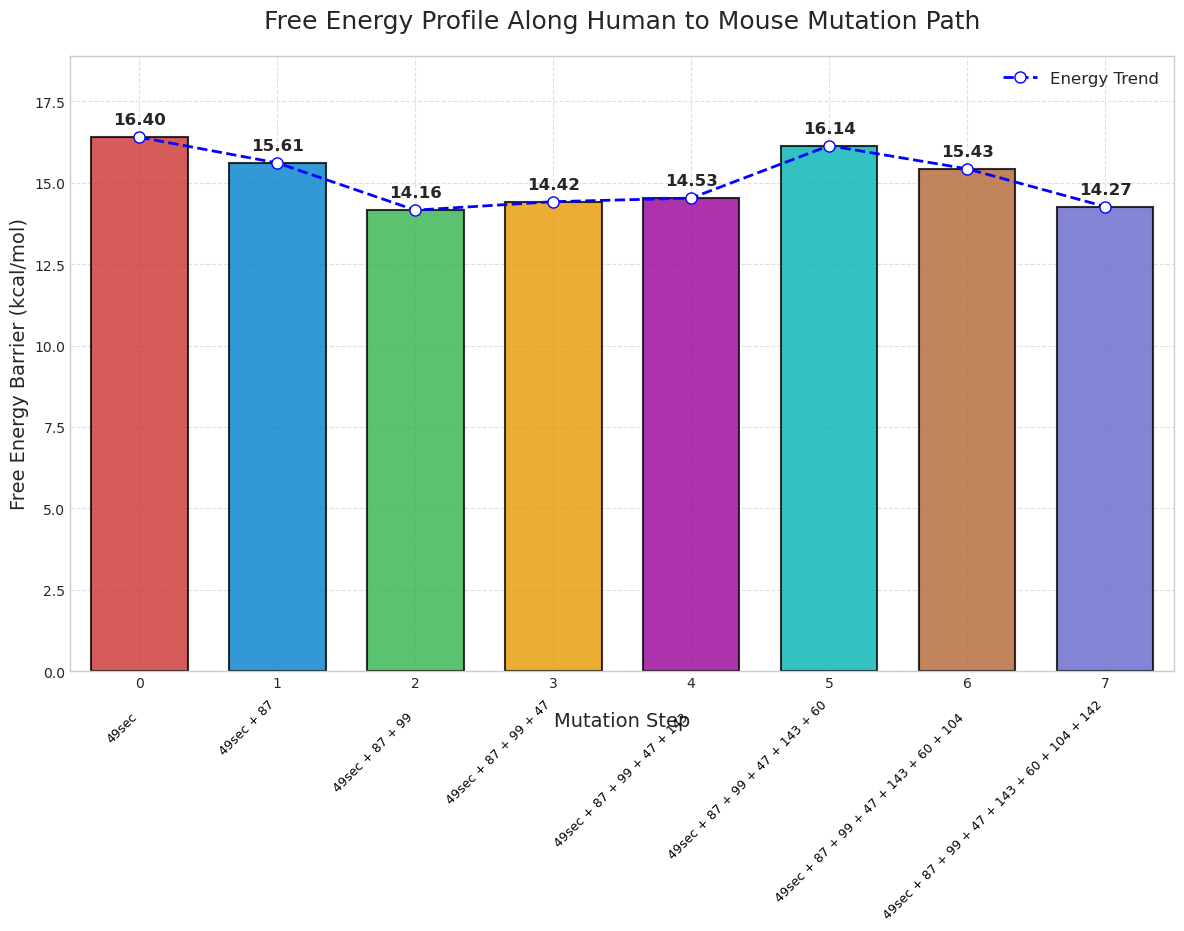

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7])
barriers = np.array([16.4, 15.61, 14.16, 14.42, 14.53, 16.14, 15.43, 14.27])
mutations = [
    "49sec",
    "49sec + 87",
    "49sec + 87 + 99",
    "49sec + 87 + 99 + 47",
    "49sec + 87 + 99 + 47 + 143",
    "49sec + 87 + 99 + 47 + 143 + 60",
    "49sec + 87 + 99 + 47 + 143 + 60 + 104",
    "49sec + 87 + 99 + 47 + 143 + 60 + 104 + 142"
]

# Define a custom colormap with distinct colors
colors_custom = [
    (0.8, 0.2, 0.2),  # Red for level 0
    (0.0, 0.5, 0.8),  # Blue for level 1
    (0.2, 0.7, 0.3),  # Green for level 2
    (0.9, 0.6, 0.0),  # Orange for level 3
    (0.6, 0.0, 0.6),  # Purple for level 4
    (0.0, 0.7, 0.7),  # Teal for level 5
    (0.7, 0.4, 0.2),  # Brown for level 6
    (0.4, 0.4, 0.8)   # Lavender for level 7
]

# Create figure
plt.figure(figsize=(12, 8))

# Create bars with custom colors
for i, (lvl, val) in enumerate(zip(levels, barriers)):
    plt.bar(lvl, val, width=0.7, color=colors_custom[i], 
            edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels
    plt.text(lvl, val + 0.3, f"{val:.2f}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add mutation labels underneath with rotation
for i, mutation in enumerate(mutations):
    if i % 2 == 0:  # Alternate label positioning for readability
        plt.text(i, -1.2, mutation, ha='right', va='top', rotation=45, 
                fontsize=9, color='black')
    else:
        plt.text(i, -0.8, mutation, ha='right', va='top', rotation=45, 
                fontsize=9, color='black')

# Add trend line
plt.plot(levels, barriers, 'o--', color='blue', markersize=8, 
         linewidth=2, markerfacecolor='white', markeredgecolor='blue',
         label="Energy Trend")

plt.title("Free Energy Profile Along Human to Mouse Mutation Path", fontsize=18, pad=20)
plt.xlabel("Mutation Step", fontsize=14, labelpad=15)
plt.ylabel("Free Energy Barrier (kcal/mol)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(levels, [f"{i}" for i in range(len(levels))])
plt.xlim(-0.5, max(levels) + 0.5)
plt.ylim(0, max(barriers) + 2.5)  # Extra space for labels and annotations

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add annotation explaining the trend
#plt.annotate('Progressive optimization \ntowards native state', 
          #  xy=(7, 13.5), xytext=(5, 16),
          #  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
          #  fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for mutation labels
plt.show()

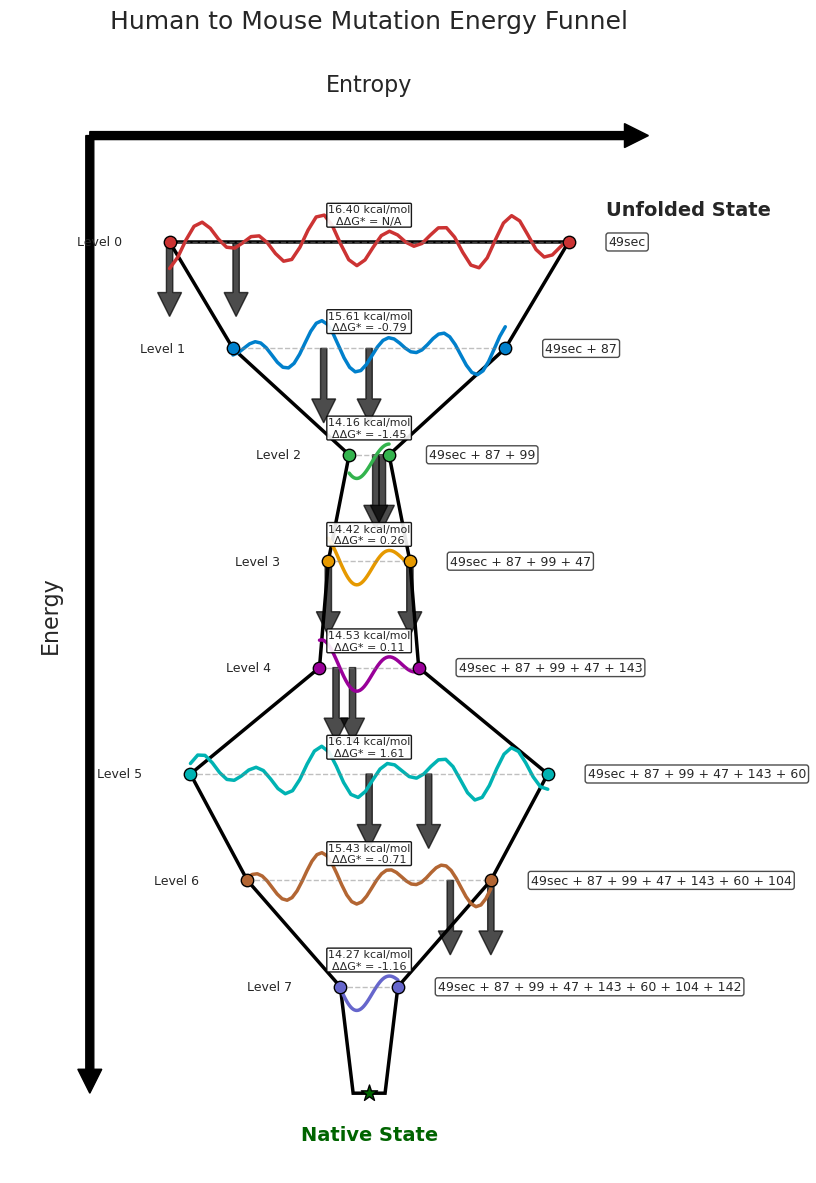

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data - updated with human to mouse mutations
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7])
barriers = np.array([16.4, 15.61, 14.16, 14.42, 14.53, 16.14, 15.43, 14.27])
mutations = [
    "49sec",
    "49sec + 87",
    "49sec + 87 + 99",
    "49sec + 87 + 99 + 47",
    "49sec + 87 + 99 + 47 + 143",
    "49sec + 87 + 99 + 47 + 143 + 60",
    "49sec + 87 + 99 + 47 + 143 + 60 + 104",
    "49sec + 87 + 99 + 47 + 143 + 60 + 104 + 142"
]

# Calculate ΔΔG* values (difference from preceding level)
ddg_values = [0]  # First level has no preceding level
for i in range(1, len(barriers)):
    ddg = barriers[i] - barriers[i-1]
    ddg_values.append(ddg)

# Color scheme
colors_custom = [
    (0.8, 0.2, 0.2),  # Red for level 0
    (0.0, 0.5, 0.8),  # Blue for level 1
    (0.2, 0.7, 0.3),  # Green for level 2
    (0.9, 0.6, 0.0),  # Orange for level 3
    (0.6, 0.0, 0.6),  # Purple for level 4
    (0.0, 0.7, 0.7),  # Teal for level 5
    (0.7, 0.4, 0.2),  # Brown for level 6
    (0.4, 0.4, 0.8)   # Lavender for level 7
]

# Create figure
plt.figure(figsize=(10, 12))
ax = plt.gca()

# Normalize energy values for consistent display
energy_min = min(barriers)
energy_max = max(barriers)
normalized_energy = [(energy_max - e + energy_min)/energy_max * 10 for e in barriers]

# Create funnel shape
# Adjust these parameters to change the funnel shape
funnel_top = 5  # Width at the top
funnel_bottom = 0.5  # Width at the bottom
funnel_height = 12  # Total height
spacing = funnel_height / (len(levels) + 1)  # Space between levels

# Calculate y-positions for each level (top to bottom)
y_positions = [funnel_height - (i+1) * spacing for i in range(len(levels))]
y_positions.append(0)  # Add bottom position for native state

# Calculate widths for each level
max_width = funnel_top
min_width = funnel_bottom
widths = []

for i, barrier in enumerate(barriers):
    # Convert energy to width (higher energy = wider funnel)
    width_factor = (barrier - energy_min) / (energy_max - energy_min)
    width = min_width + width_factor * (max_width - min_width)
    widths.append(width)

# Add native state at the bottom (narrowest point)
widths.append(min_width * 0.8)

# Draw funnel outline
x_points = []
y_points = []

# Right side (top to bottom)
for i in range(len(widths)):
    x_points.append(widths[i]/2)
    y_points.append(y_positions[i])

# Left side (bottom to top) - add points in reverse
for i in range(len(widths)-1, -1, -1):
    x_points.append(-widths[i]/2)
    y_points.append(y_positions[i])

# Close the path
x_points.append(widths[0]/2)
y_points.append(y_positions[0])

# Create a path for the funnel outline
funnel_path = Path(list(zip(x_points, y_points)))
funnel_patch = patches.PathPatch(funnel_path, facecolor='none', edgecolor='black', linewidth=2.5)
ax.add_patch(funnel_patch)

# Create the level contours (horizontal lines with bumps)
for i in range(len(levels)):
    # Energy contour coordinates
    y = y_positions[i]
    width = widths[i]
    
    # Basic horizontal line
    x_left = -width/2
    x_right = width/2
    
    # Create points for a bumpy line representing energy landscape
    x_bumps = np.linspace(x_left, x_right, 50)
    y_bumps = y + np.sin(x_bumps * 8) * 0.2 - np.cos(x_bumps * 5) * 0.15  # Add waves
    
    # Plot the bumpy energy landscape level
    plt.plot(x_bumps, y_bumps, '-', color=colors_custom[i], linewidth=2.5)
    
    # Add a horizontal marker line
    plt.plot([x_left, x_right], [y, y], '--', color='gray', alpha=0.5, linewidth=1)

    # Add level markers on both sides
    # Left side
    plt.scatter(x_left, y, s=80, color=colors_custom[i], edgecolor='black', zorder=5)
    plt.text(x_left - 0.6, y, f"Level {i}", fontsize=9, ha='right', va='center')
    
    # Right side - mutation info
    plt.scatter(x_right, y, s=80, color=colors_custom[i], edgecolor='black', zorder=5)
    plt.text(x_right + 0.5, y, mutations[i], fontsize=9, ha='left', va='center',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
    
    # Energy value and ΔΔG* information
    ddg_text = f"ΔΔG* = {ddg_values[i]:.2f}" if i > 0 else "ΔΔG* = N/A"
    energy_text = f"{barriers[i]:.2f} kcal/mol\n{ddg_text}"
    plt.text(0, y + 0.2, energy_text, fontsize=8, ha='center', va='bottom',
            bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.1'))

# Add native state at the bottom
bottom_y = y_positions[-1]
plt.scatter(0, bottom_y, s=150, color='darkgreen', marker='*', edgecolor='black', zorder=5)
plt.text(0, bottom_y - 0.4, "Native State", fontsize=14, fontweight='bold', 
        ha='center', va='top', color='darkgreen')

# Add arrows showing direction toward native state
arrow_count = 14
for i in range(arrow_count):
    # Determine arrow starting point
    level = int(i / 2)  # Distribute across levels
    if level >= len(y_positions) - 1:
        level = len(y_positions) - 2
    
    y_start = y_positions[level] 
    x_fraction = (i % 7) / 6  # Distribute horizontally
    
    # Calculate width at this level
    if level < len(widths):
        width = widths[level]
    else:
        width = widths[-1]
    
    x_start = -width/2 + width * x_fraction
    
    # Calculate arrow angle (point down and slightly inward)
    angle = -90  # Down
    if x_start < 0:
        angle -= 15  # Down and right
    elif x_start > 0:
        angle -= -15  # Down and left
    
    # Draw the arrow
    plt.arrow(x_start, y_start, 0, -spacing*0.7, width=0.08, 
              head_width=0.3, head_length=0.3, 
              fc='black', ec='black', alpha=0.7,
              length_includes_head=True)

# Add entropy and energy axis labels
plt.text(0, funnel_height + 0.5, "Entropy", fontsize=16, ha='center', va='bottom')
plt.arrow(-funnel_top/2 - 1, funnel_height, funnel_top + 2, 0, width=0.1, 
         head_width=0.3, head_length=0.3, fc='black', ec='black', 
         length_includes_head=True)

plt.text(-funnel_top/2 - 1.5, funnel_height/2, "Energy", fontsize=16, rotation=90, va='center', ha='center')
plt.arrow(-funnel_top/2 - 1, funnel_height, 0, -funnel_height, width=0.1, 
         head_width=0.3, head_length=0.3, fc='black', ec='black',
         length_includes_head=True)

# Add top state label (only keep unfolded state)
plt.text(4, funnel_height - 1, "Unfolded State", fontsize=14, fontweight='bold', ha='center')

# Set up axes
ax.set_xlim(-funnel_top/2 - 2, funnel_top/2 + 2)
ax.set_ylim(-1, funnel_height + 1)
ax.set_aspect('equal')
ax.axis('off')  # Hide the axes
plt.title("Human to Mouse Mutation Energy Funnel", fontsize=18, pad=20)

plt.tight_layout()
plt.savefig('human_to_mouse_energy_funnel.png', dpi=300, bbox_inches='tight')
plt.show()

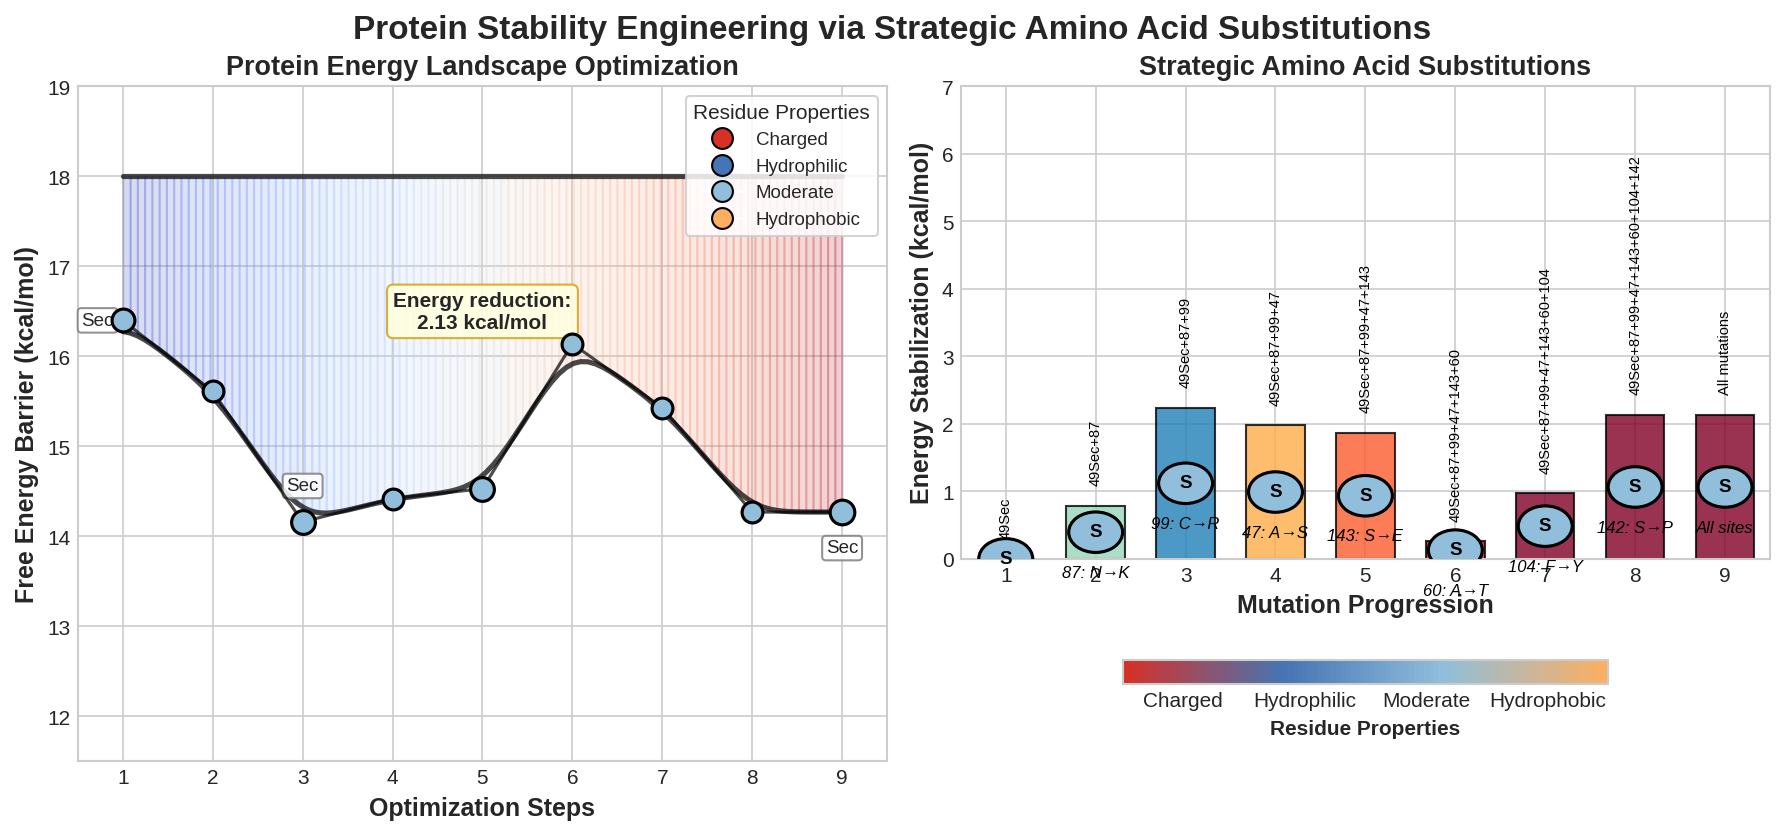

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib import cm
from scipy.ndimage import gaussian_filter1d

# Use a clean style
plt.style.use('seaborn-v0_8-whitegrid')

# Create a clean figure with customized layout
fig = plt.figure(figsize=(12, 6), dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Define data from the original visualization with updated mutation information
# FIX: Adjust levels to match barriers length
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7])
barriers = np.array([16.4, 15.61, 14.16, 14.42, 14.53, 16.14, 15.43, 14.27])

# Add level 8 barrier (same as last barrier for now - you can adjust as needed)
levels = np.append(levels, 8)
barriers = np.append(barriers, 14.27)  # Using the same value as the last one

# Updated mutation labels as requested
mutations = ["49Sec", "49Sec+87", "49Sec+87+99", "49Sec+87+99+47", 
             "49Sec+87+99+47+143", "49Sec+87+99+47+143+60", 
             "49Sec+87+99+47+143+60+104", "49Sec+87+99+47+143+60+104+142", 
             "All mutations"]

# Residue information with actual mutations
mutation_positions = [49, 87, 99, 47, 143, 60, 104, 142]
mutation_changes = ["Cys→Sec", "N→K", "C→R", "A→S", "S→E", "A→T", "F→Y", "S→P"]

# Add amino acid properties
hydrophobicity = {
    'Cys': 2.5,  
    'Sec': 2.0,  
    'Ala': 1.8,  
    'Val': 4.2,  
    'Ile': 4.5,  
    'Leu': 3.8,  
    'Met': 1.9,  
    'Phe': 2.8,
    'Tyr': 1.3,
    'Trp': 3.4,
    'Pro': 1.6,
    'Gly': 0.9,
    'His': 0.5,
    'Gln': 0.2,
    'Asn': 0.2,
    'Thr': 0.7,
    'Ser': 0.6,
    'Lys': -0.9,
    'Arg': -1.1,
    'Glu': -0.7
}

mutation_aa = {
    0: 'Sec', 1: 'Sec', 2: 'Sec', 3: 'Sec', 4: 'Sec',
    5: 'Sec', 6: 'Sec', 7: 'Sec', 8: 'Sec'
}

# Define hydrophilic/hydrophobic classification
def classify_aa(h_value):
    if h_value < 0.0:
        return "Charged"
    elif h_value < 2.0:
        return "Hydrophilic"
    elif h_value < 3.0:
        return "Moderate"
    else:
        return "Hydrophobic"

# Create a more attractive color palette
def hydro_color(h_value):
    if h_value < 0.0:  # Charged
        return '#d73027'  # Red
    elif h_value < 2.0:  # Hydrophilic
        return '#4575b4'  # Blue
    elif h_value < 3.0:  # Moderately hydrophobic
        return '#91bfdb'  # Light blue
    else:  # Strongly hydrophobic
        return '#fdae61'  # Orange-yellow

# Get classification for each AA
mutation_hydrophobicity = [hydrophobicity[mutation_aa[i]] for i in range(len(levels))]
mutation_class = [classify_aa(h) for h in mutation_hydrophobicity]

colors = [hydro_color(h) for h in mutation_hydrophobicity]

# ============= LEFT PANEL: Professional Energy Funnel =============
ax1 = plt.subplot(gs[0])

# Create smoother funnel curve for energy surface
x_smooth = np.linspace(0, 8, 100)
# Create a smooth curve for the funnel's lower bound
smooth_curve = np.interp(x_smooth, levels, barriers)
# Apply a little smoothing
smooth_curve = gaussian_filter1d(smooth_curve, sigma=3)

# Fill the funnel with a gradient
top_line = np.ones_like(x_smooth) * 18
# Create color gradient from blue to red
colors_gradient = cm.coolwarm(np.linspace(0, 1, len(x_smooth)))
# Plot filled area with gradient
for i in range(len(x_smooth)-1):
    ax1.fill_between(x_smooth[i:i+2], smooth_curve[i:i+2], top_line[i:i+2], 
                     color=colors_gradient[i], alpha=0.2)

# Draw a smooth curve for the energy barrier
ax1.plot(x_smooth, smooth_curve, 'k-', lw=2.5, alpha=0.7)
# Add top line of funnel
ax1.plot([0, 8], [18, 18], 'k-', lw=2.5, alpha=0.7)

# Plot the actual data points with customized markers
point_sizes = [120, 100, 130, 100, 130, 100, 100, 100, 140]
for i in range(len(levels)):
    # Main point
    ax1.scatter(levels[i], barriers[i], s=point_sizes[i], color=colors[i], 
               edgecolor='black', zorder=10, linewidth=1.5)

# Connect points with line segments to show the optimization path
ax1.plot(levels, barriers, 'k-', lw=1.5, alpha=0.7, zorder=5)

# Only label key points without overlap
key_points = [0, 2, 8]  # Reduced key points to avoid overlaps
for i in key_points:
    if i == 0:  # First point
        ax1.annotate(f"{mutation_aa[i]}", 
                   (levels[i]-0.1, barriers[i]),
                   fontsize=9, ha='right', va='center',
                   bbox=dict(facecolor='white', alpha=0.85, 
                            boxstyle='round,pad=0.2', edgecolor='gray'))
    elif i == 2:  # Sec point
        ax1.annotate(f"Sec", 
                   (levels[i], barriers[i]+0.4),
                   fontsize=9, ha='center', va='center',
                   bbox=dict(facecolor='white', alpha=0.85, 
                            boxstyle='round,pad=0.2', edgecolor='gray'))
    elif i == 8:  # Final point
        ax1.annotate(f"Sec", 
                   (levels[i], barriers[i]-0.4),
                   fontsize=9, ha='center', va='center',
                   bbox=dict(facecolor='white', alpha=0.85, 
                            boxstyle='round,pad=0.2', edgecolor='gray'))

# Add legend for hydrophobicity with more attractive styling
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#d73027',
              markeredgecolor='black', markersize=10, label='Charged'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4575b4',
              markeredgecolor='black', markersize=10, label='Hydrophilic'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#91bfdb',
              markeredgecolor='black', markersize=10, label='Moderate'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#fdae61',
              markeredgecolor='black', markersize=10, label='Hydrophobic')
]
ax1.legend(handles=legend_elements, loc='upper right', frameon=True, 
          framealpha=0.85, fontsize=9, title='Residue Properties')

# Add labels and title with improved styling
ax1.set_xlabel('Optimization Steps', fontsize=12, fontweight='bold')
ax1.set_ylabel('Free Energy Barrier (kcal/mol)', fontsize=12, fontweight='bold')
ax1.set_title('Protein Energy Landscape Optimization', fontsize=13, fontweight='bold')
ax1.set_xlim(-0.5, 8.5)
ax1.set_ylim(11.5, 19)
ax1.set_xticks(levels)
ax1.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9'])

# Add energy reduction annotation
energy_reduction = barriers[0] - barriers[-1]
ax1.annotate(f"Energy reduction:\n{energy_reduction:.2f} kcal/mol", 
           (4, 16.5), fontsize=10, ha='center', va='center',
           bbox=dict(facecolor='lightyellow', alpha=0.9, 
                    edgecolor='goldenrod', boxstyle='round,pad=0.3'),
           fontweight='bold')

# ============= RIGHT PANEL: Enhanced Amino Acid Changes Visualization =============
ax2 = plt.subplot(gs[1])

# Create bars showing energy improvement
bar_heights = barriers[0] - barriers  # Energy improvement
bar_colors = [cm.YlGnBu(i/3) if i < 3 else cm.YlOrRd(0.4 + (i-3)/5) for i in range(len(levels))]

# Add bars with smoother edges
width = 0.65
bars = ax2.bar(levels, bar_heights, width=width, color=bar_colors, 
              edgecolor='black', linewidth=1, alpha=0.8)

# Define position-specific mutations
position_mutations = {
    0: "49Sec",
    1: "49Sec+87(N→K)",
    2: "49Sec+87+99(C→R)",
    3: "49Sec+87+99+47(A→S)",
    4: "49Sec+87+99+47+143(S→E)",
    5: "49Sec+87+99+47+143+60(A→T)",
    6: "49Sec+87+99+47+143+60+104(F→Y)",
    7: "49Sec+87+99+47+143+60+104+142(S→P)",
    8: "All mutations"
}

# Add position labels above bars for key mutations
for i in range(len(levels)):
    ax2.text(levels[i], bar_heights[i] + 0.3, mutations[i], 
            rotation=90, ha='center', va='bottom', 
            fontsize=7, color='black')

# Add amino acid information with improved presentation
circle_size = 0.3
for i, (x, height) in enumerate(zip(levels, bar_heights)):
    # Position for amino acid symbol
    symbol_y = height/2
    
    # Add amino acid circle 
    circle = Circle((x, symbol_y), circle_size, 
                   facecolor=colors[i], alpha=1.0,
                   edgecolor='black', linewidth=1.5, zorder=10)
    ax2.add_patch(circle)
    
    # Add amino acid label inside circle
    aa_label = "Sec"
    
    ax2.text(x, symbol_y, aa_label[0], 
            ha='center', va='center', 
            fontsize=9, fontweight='bold', 
            color='black', zorder=11)
    
    # For mutations after position 0, add the most recent mutation below
    if i > 0:
        if i == 1:  # 87 N→K
            mut_text = "87: N→K"
        elif i == 2:  # 99 C→R
            mut_text = "99: C→R"
        elif i == 3:  # 47 A→S
            mut_text = "47: A→S"
        elif i == 4:  # 143 S→E
            mut_text = "143: S→E"
        elif i == 5:  # 60 A→T
            mut_text = "60: A→T"
        elif i == 6:  # 104 F→Y
            mut_text = "104: F→Y"
        elif i == 7:  # 142 S→P
            mut_text = "142: S→P"
        elif i == 8:  # All mutations
            mut_text = "All sites"
            
        ax2.text(x, symbol_y - 0.6, mut_text, 
                ha='center', va='center', 
                fontsize=8, color='black', style='italic')

# Add labels and title with improved styling
ax2.set_xlabel('Mutation Progression', fontsize=12, fontweight='bold')
ax2.set_ylabel('Energy Stabilization (kcal/mol)', fontsize=12, fontweight='bold')
ax2.set_title('Strategic Amino Acid Substitutions', fontsize=13, fontweight='bold')
ax2.set_xlim(-0.5, 8.5)
ax2.set_ylim(0, 7)
ax2.set_xticks(levels)
ax2.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9'])

# Add hydrophobicity scale with improved gradient
cmap = LinearSegmentedColormap.from_list('hydrophobicity', 
                                       ['#d73027', '#4575b4', '#91bfdb', '#fdae61'], 
                                       N=100)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal', shrink=0.6, pad=0.15)
cbar.set_label('Residue Properties', fontsize=10, fontweight='bold')
cbar.ax.set_xticks([0.125, 0.375, 0.625, 0.875])
cbar.ax.set_xticklabels(['Charged', 'Hydrophilic', 'Moderate', 'Hydrophobic'])

# Add main title for the whole figure
fig.suptitle('Protein Stability Engineering via Strategic Amino Acid Substitutions', 
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)
plt.show()